# 微表情检测分类

简单的实现思路是对每一个表情文件夹下的图片中均匀分组，每一组选取一张图片，然后将所有的图片按照时间顺序合并为一个三维的数组输入到CNN模型中

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import os
import re
import math

In [68]:
# 超参数
T = 8

## 读取数据集

In [69]:
data_path = '..\\datasets\\cropped-by Li Xiaobai\\Cropped'
info_path = "..\\datasets\\cropped-by Li Xiaobai\\Cropped\\info.csv"

info = pd.read_csv(info_path)
info

,Unnamed: 0,Subject,Filename,OnsetF,ApexF1,OffsetF,Onset,Total,AU,Emotion
0,0,1,EP01_12,73,81,91,150.000000,316.6666666666667,4,tense
1,1,1,EP01_12,163,169,177,116.666667,250,4,tense
2,2,1,EP01_5,113,121,133,150.000000,350,12,happiness
3,3,1,EP01_8,67,75,81,150.000000,250,14,repression
4,4,1,EP03_1,79,91,105,216.666667,450,17,repression
...,...,...,...,...,...,...,...,...,...,...
192,96,19,EP07_9,46,55,90,150.000000,733.3333333333334,L14,repression
193,97,19,EP09_3,106,111,120,83.333333,233.33333333333334,4,tense
194,98,19,EP12_1,91,95,111,66.666667,333.3333333333333,1+2,surprise
195,99,19,EP12_2,39,48,57,150.000000,300,4,tense


In [70]:
# 获取labels
from sklearn.preprocessing import LabelEncoder


lbe = LabelEncoder()
y_labels = info["Emotion"].values.tolist()
lbe_res = lbe.fit_transform(y_labels)
print(len(lbe.classes_))
lbe.classes_

8


array(['comtempt', 'disgust', 'fear', 'happiness', 'repression',
       'sadness', 'surprise', 'tense'], dtype='<U10')

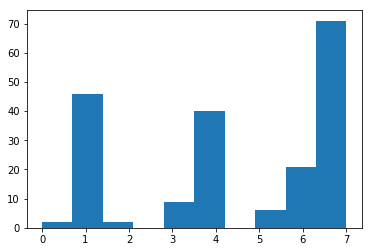

In [71]:
plt.hist(lbe_res, )
plt.show()

In [72]:
def randomChoseGroup(files, T=6):
    """
    对列表均匀分组，每一组中随机选择一个sample
    input:
        files: 文件名列表
        T:     分组数，默认为6
    output:
        chose_imgs: 随机分组得到的名称
    """
    length = len(files)
    interval = int(length / T)
    chose_imgs = list()
    for i in range(T):
        chose_img = random.sample(files[i*interval:(i+1)*interval], 1)[0]
        chose_imgs.append(chose_img)
    return chose_imgs
# imgs = [str(i) for i in range(100)]
# print(randomChoseGroup(imgs, 6))

In [73]:
# 列表排序key
def sort_key(s):
    if s:
        try:
            c=re.findall('\d+$', s)[0]
        except:
            c=-1
        return int(c)
# 读取序列表情图片
expressions = list()
labels = list()
count = 0
chose_emotion = ['disgust', 'repression', 'tense']
for i in range(len(info)):
    subname = "sub" + str(info['Subject'].iloc[i]).rjust(2, '0')
    filename = info['Filename'].iloc[i]
    file_path = os.path.join(data_path, subname, filename)

    imgs = os.listdir(file_path)
    if len(imgs) >= 10:
        chose_imgs = randomChoseGroup(imgs)
        chose_imgs.sort(key=sort_key, reverse=False)
        expression = np.zeros([T, 64, 64])
        for j in range(len(chose_imgs)):
            img = cv2.imread(os.path.join(file_path, chose_imgs[j]), cv2.IMREAD_GRAYSCALE)
            # print(img.shape)
            expression[j, :, :] = cv2.resize(img,(64, 64))

        expressions.append(expression)
        # if info['Emotion'].iloc[i] in ['disgust', 'repression', 'tense']:
        #     labels.append(info['Emotion'].iloc[i])
        # else:
        #     labels.append('other')
        labels.append(info['Emotion'].iloc[i])
expressions = np.array(expressions)

In [74]:
expressions.shape

(195, 8, 64, 64)

In [75]:
# 获取labels
from sklearn.preprocessing import LabelEncoder


lbe = LabelEncoder()
lbe_res = lbe.fit_transform(labels)
print(len(lbe.classes_))
lbe.classes_

8


array(['comtempt', 'disgust', 'fear', 'happiness', 'repression',
       'sadness', 'surprise', 'tense'], dtype='<U10')

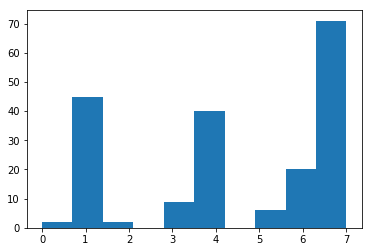

In [76]:
plt.hist(lbe_res)
plt.show()

[ 56 185 155   0 192 140]


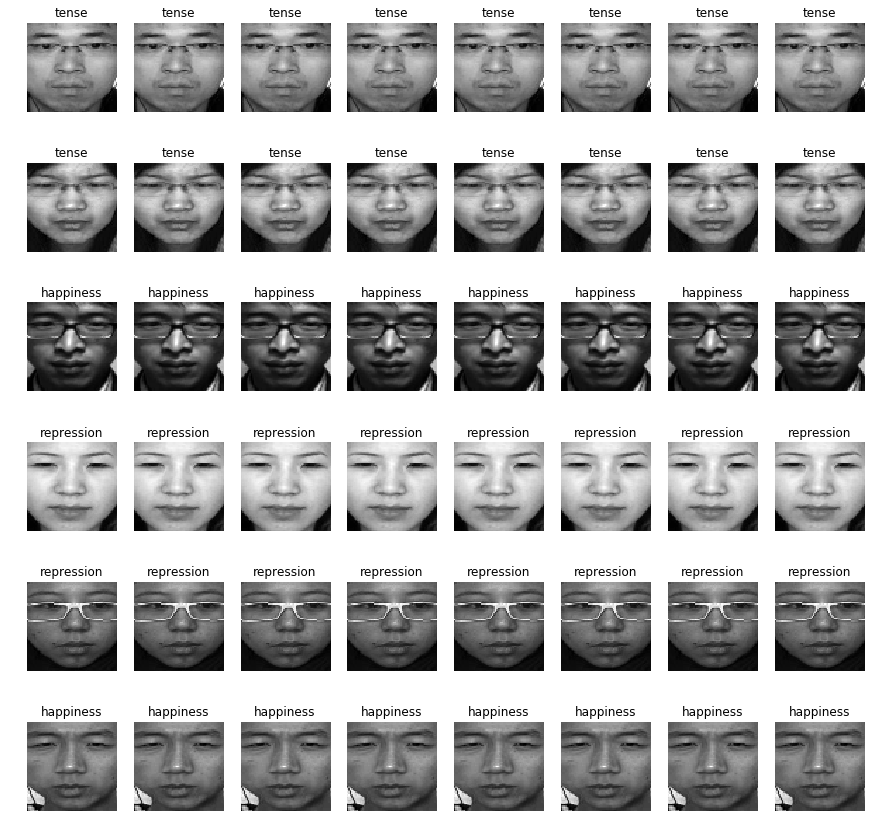

In [78]:
# 查看读取的图片
chose_indexs = np.random.randint(0, len(expressions), 6)
# chose_indexs = np.arange(5)
print(chose_indexs)
plt.figure(figsize=(15, 15))
for j in range(len(chose_indexs)):
    for i in range(T):
        plt.subplot(len(chose_indexs), T, j*T+i+1)
        plt.imshow(expressions[chose_indexs[j]][0, :,:], cmap='gray')
        plt.axis('off')
        plt.title(labels[j])
plt.show()

In [ ]:
# 以numpy形式保存训练图片和标签
np.save("..\\datasets\\train_images.npy", expressions)
np.save("..\\datasets\\train_labels.npy", lbe_res)

## LBP-TOP提取特征，xgboost分类

这种方法可能是LBP-TOP算法写的有点问题，分类准确率较低为0.425

In [ ]:
def LBP_TOP(VolData, xRadius=1, yRadius=1, tInterval=1, NeighborPoints=[6, 6, 6], TimeLength=1, BorderLength=1):
    """
    LBP-TOP算法
    input:
        VolData:         一段表情序列图像集
        xRadius:         在X轴上半径，默认为1
        yRadius:         在Y轴上半径，默认为1
        tInterval:       在T轴上半径，默认为4
        NeightborPoints: 在XY, XT, YT平面上所选取的领域像素点个数，默认值为8,6,6
    output:
        Historgram:      输出的LBP-TOP特征矩阵
    """
    length, height, width = VolData.shape

    XYNeighborPoints = NeighborPoints[0]
    XTNeighborPoints = NeighborPoints[1]
    YTNeighborPoints = NeighborPoints[2]

    nDim = 2 ** (YTNeighborPoints)
    Historgram = np.zeros((3, nDim), float)

    for t in range(TimeLength, length - TimeLength):
        for yc in range(BorderLength, height - BorderLength):
            for xc in range(BorderLength, width - BorderLength):
                CenterVal = VolData[t, yc, xc]

                # XY平面上
                BasicLBP = 0
                feaBin = 0

                for p in range(0, XYNeighborPoints):
                    X = int(xc + xRadius * math.cos((2 * math.pi * p)/XYNeighborPoints) + 0.5)
                    Y = int(yc - yRadius * math.sin((2 * math.pi * p)/XYNeighborPoints) + 0.5)
                    
                    CurrentVal = VolData[t, Y, X]

                    if CurrentVal >= CenterVal:
                        BasicLBP += 2 ** feaBin
                    
                    feaBin += 1

                Historgram[0, BasicLBP] = Historgram[0, BasicLBP] + 1

                # XT平面上
                BasicLBP = 0
                feaBin = 0

                for p in range(0, XTNeighborPoints):
                    X = int(xc + xRadius * math.cos((2 * math.pi * p) / XTNeighborPoints) + 0.5)
                    Z = int(t + tInterval * math.sin((2 * math.pi * p) / XTNeighborPoints)+ 0.5)
                    CurrentVal = VolData[Z, yc, X]

                    if CurrentVal >= CenterVal:
                        BasicLBP += 2 ** feaBin

                    feaBin += 1

                Historgram[1, BasicLBP] = Historgram[1, BasicLBP] + 1

                # YT平面上
                BasicLBP = 0
                feaBin = 0

                for p in range(0, YTNeighborPoints):
                    Y = int(yc - yRadius * math.cos((2 * math.pi * p)/YTNeighborPoints) + 0.5)
                    Z = int(t + tInterval * math.sin((2 * math.pi * p)/YTNeighborPoints) + 0.5)

                    CurrentVal = VolData[Z, Y, xc]

                    if CurrentVal >= CenterVal:
                        BasicLBP += 2 ** feaBin

                    feaBin += 1
                
                Historgram[2, BasicLBP] = Historgram[2, BasicLBP] + 1

    # 规范化
    for j in range(3):
        Historgram[j, :] = (Historgram[j, :] * 1.0) / sum(Historgram[j, :])
    
    return Historgram

In [ ]:
historgram = LBP_TOP(expressions[115]).reshape((3*64, 1))
plt.plot(np.arange(3*64), historgram)
plt.show()

In [ ]:
historgram.shape

In [ ]:
# lbe_res = lbe_res - 1
lbe_res

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer

In [ ]:
# 获取x_data
x_data = list()
count = 1
for expression in expressions:
    x_data.append(LBP_TOP(expression/255))
    print('\r' + '▇'*(count//2) + "{:.3f}".format(count * 100.0 / float(len(expressions))) + '%', end='')
    count += 1
x_data = np.array(x_data)
x_data.shape

In [ ]:
x_data_resize = x_data.reshape((len(x_data), 3*64))
X_train, X_test, y_train, y_test = train_test_split(x_data_resize, lbe_res, test_size=0.2)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
clf = XGBClassifier(n_estimators=1000, learning_rate=0.005, n_jobs=4)
clf.fit(X_train, y_train,
        early_stopping_rounds=20,
        eval_set=[(X_test, y_test)],
        verbose=False)

In [ ]:
y_pred = clf.predict(X_test)
y_pred

In [ ]:
y_test

In [ ]:
(y_pred == y_test).sum()/len(y_pred)

In [ ]:
classification_report(y_test, y_pred)

In [ ]:
confusion_matrix(y_test, y_pred)

## CNN网络分类尝试

In [51]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.convolutional import Convolution3D, MaxPooling3D
from tensorflow.keras.optimizers import SGD, RMSprop
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import os
import numpy as np

In [38]:
# 读取数据
images = np.load("..\\datasets\\train_images.npy")
labels = np.load("..\\datasets\\train_labels.npy")

In [40]:
images = images.astype('float32')
images -= np.mean(images)
images /= np.std(images)

In [41]:
images_reshape = images.reshape((images.shape[0], 1, images.shape[1], images.shape[2], images.shape[3]))
images_reshape.shape

(195, 1, 8, 64, 64)

In [42]:
labels_onehot = np.zeros((len(labels), ), dtype=int)
labels_onehot = np_utils.to_categorical(labels, 8)
labels_onehot.shape

(195, 8)

In [57]:
train_images, validation_images, train_labels, validation_labels =  train_test_split(images_reshape, labels_onehot, test_size=0.2, random_state=4)

In [44]:
train_images.shape

(156, 1, 8, 64, 64)

In [45]:
image_depth, image_rows, image_columns = train_images[0, 0].shape

In [46]:
# 定义3维cnn模型
model = Sequential()
model.add(Convolution3D(8, (3, 3, 15), input_shape=(1, image_depth, image_rows, image_columns), activation='relu', data_format='channels_first'))
model.add(MaxPooling3D(pool_size=(3, 3, 3)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, init='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_labels.shape[1], init='normal'))
model.add(Activation('softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 8, 6, 62, 50)      1088      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 2, 2, 20, 50)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 2, 2, 20, 50)      0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               512128    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1032      
__________

C:\Users\Administrator\.conda\envs\python3.6env\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="normal")`
  '` call to the Keras 2 API: ' + signature)
C:\Users\Administrator\.conda\envs\python3.6env\lib\site-packages\keras\legacy\interfaces.py:86: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(8, kernel_initializer="normal")`
  '` call to the Keras 2 API: ' + signature)


In [47]:
filepath="models\\weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [48]:
hist = model.fit(train_images, train_labels, validation_data = (validation_images, validation_labels), callbacks=callbacks_list, batch_size = 16, nb_epoch = 100, shuffle=True)

C:\Users\Administrator\.conda\envs\python3.6env\lib\site-packages\keras\models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 156 samples, validate on 39 samples
Epoch 1/100
156/156 [==============================] - 6s - loss: 3.9126 - acc: 0.1859 - val_loss: 1.7508 - val_acc: 0.3333
Epoch 2/100
156/156 [==============================] - 6s - loss: 2.0304 - acc: 0.3205 - val_loss: 1.7207 - val_acc: 0.3590
Epoch 3/100
156/156 [==============================] - 6s - loss: 1.9052 - acc: 0.3141 - val_loss: 1.7214 - val_acc: 0.3077
Epoch 4/100
156/156 [==============================] - 6s - loss: 1.7248 - acc: 0.3141 - val_loss: 1.6857 - val_acc: 0.3846
Epoch 5/100
156/156 [==============================] - 6s - loss: 1.8214 - acc: 0.3397 - val_loss: 1.7076 - val_acc: 0.4103
Epoch 6/100
156/156 [==============================] - 6s - loss: 1.6156 - acc: 0.3910 - val_loss: 1.6080 - val_acc: 0.4103
Epoch 7/100
156/156 [==============================] - 6s - loss: 1.6875 - acc: 0.3846 - val_loss: 1.6168 - val_acc: 0.3590
Epoch 8/100
156/156 [==============================] - 6s - loss: 1.5737 - acc: 0.5000 

In [60]:
predictions = model.predict(validation_images)
predictions_labels = np.argmax(predictions, axis=1)
validation_labels = np.argmax(validation_labels, axis=1)
cfm = confusion_matrix(validation_labels, predictions_labels)
print (cfm)

[[10  0  1  0  0  0  2]
 [ 0  0  0  0  0  0  1]
 [ 0  0  0  1  0  0  0]
 [ 1  0  0  1  0  0  6]
 [ 1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2]
 [ 3  0  0  1  0  0  9]]
